# Simulation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import scvi

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import scp.simulations as sm
import scp.plots as pl
from scp.models import PROTVI

scvi.settings.seed = 0
sm.fix_seed(0)

/home/rasmus/anaconda3/envs/scp/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/rasmus/anaconda3/envs/scp/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
Global seed set to 0


## Generation

In [2]:
n_datasets = 10

datasets = []
for i in range(n_datasets):
    adata = sm.simulate_two_groups(n_de_proteins=300, log2_fold_change=2)
    datasets.append(adata)

## Inspection

Let's look at one of the simulated datasets.

In [3]:
adata = datasets[0]

print(f"Number of cells: {adata.n_obs}")
print(f"Number of proteins: {adata.n_vars}")

mask = adata.layers["detected"]
n_obs = np.mean(mask)

print(f"Observed intensities: {n_obs*100:.2f}%")

Number of cells: 1000
Number of proteins: 900
Observed intensities: 65.42%


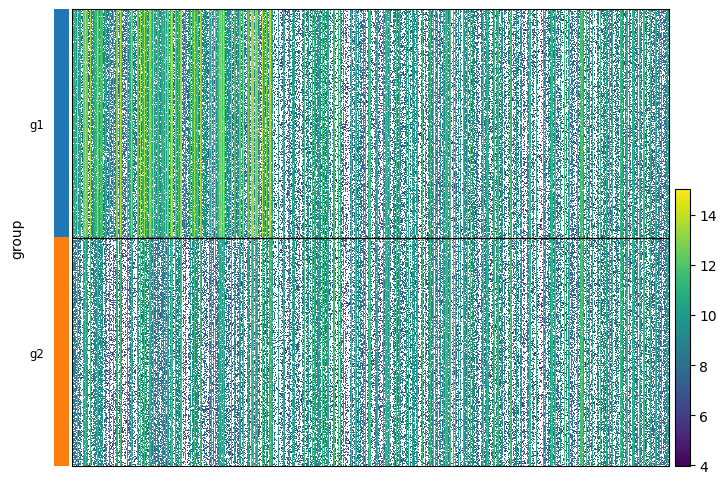

In [4]:
adata.X = adata.layers["intensity"].copy()
adata.X[adata.layers["detected"] == 0] = np.nan

sc.pl.heatmap(adata, var_names=adata.var_names, groupby="group", show_gene_labels=False)

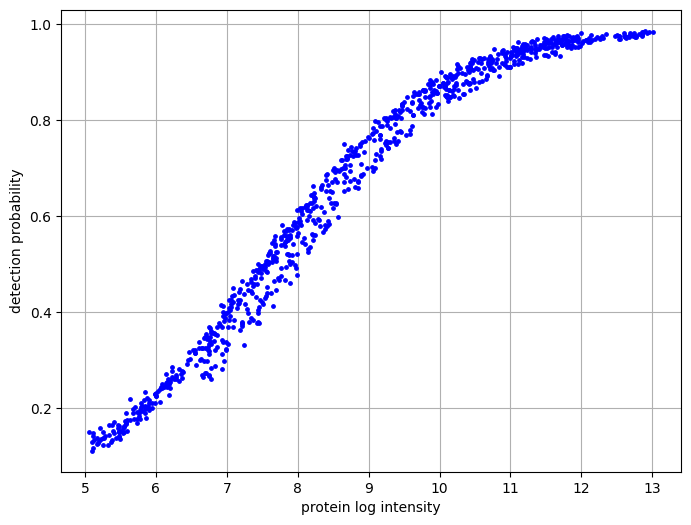

In [5]:
x = adata.layers["intensity"].copy()
x[adata.layers["detected"] == 0] = np.nan

pl.scatter_protein_detection_probability_and_intensity(x)

## Modelling

Let's fit a few models to the data.

### PROTVI

In [6]:
adata = datasets[0]

In [7]:
adata.X = adata.layers["intensity"] * adata.layers["detected"]

In [8]:
PROTVI.setup_anndata(adata)

model = PROTVI(adata, log_variational=False)
#model.view_anndata_setup()

In [ ]:
model.train(max_epochs=1000)

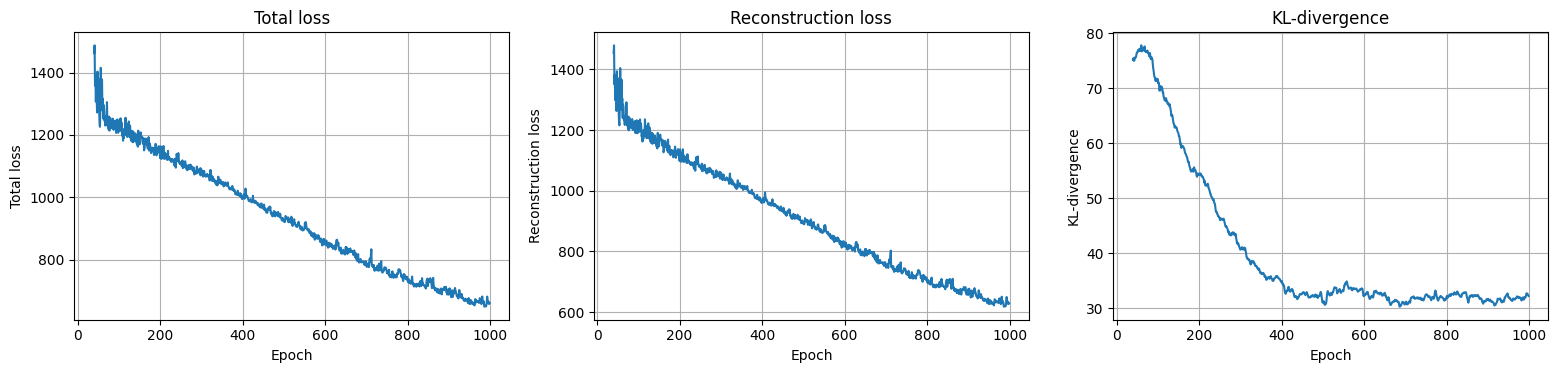

In [10]:
pl.plot_loss(model.history, n_skip=40)

In [11]:
x_est, p_est = model.impute(adata)

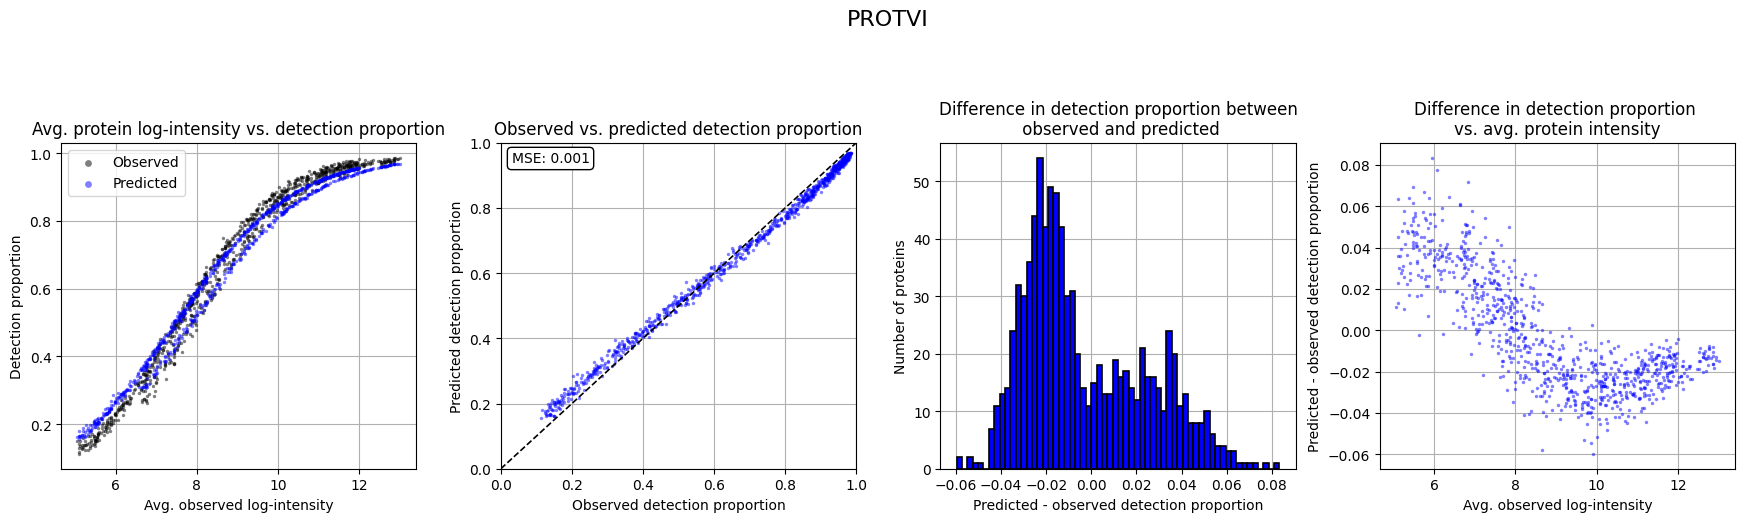

In [12]:
x_data = adata.layers["intensity"].copy()
x_data[~adata.layers["detected"]] = np.nan

pl.plot_protein_detection_probability_panel(x_data, p_est)

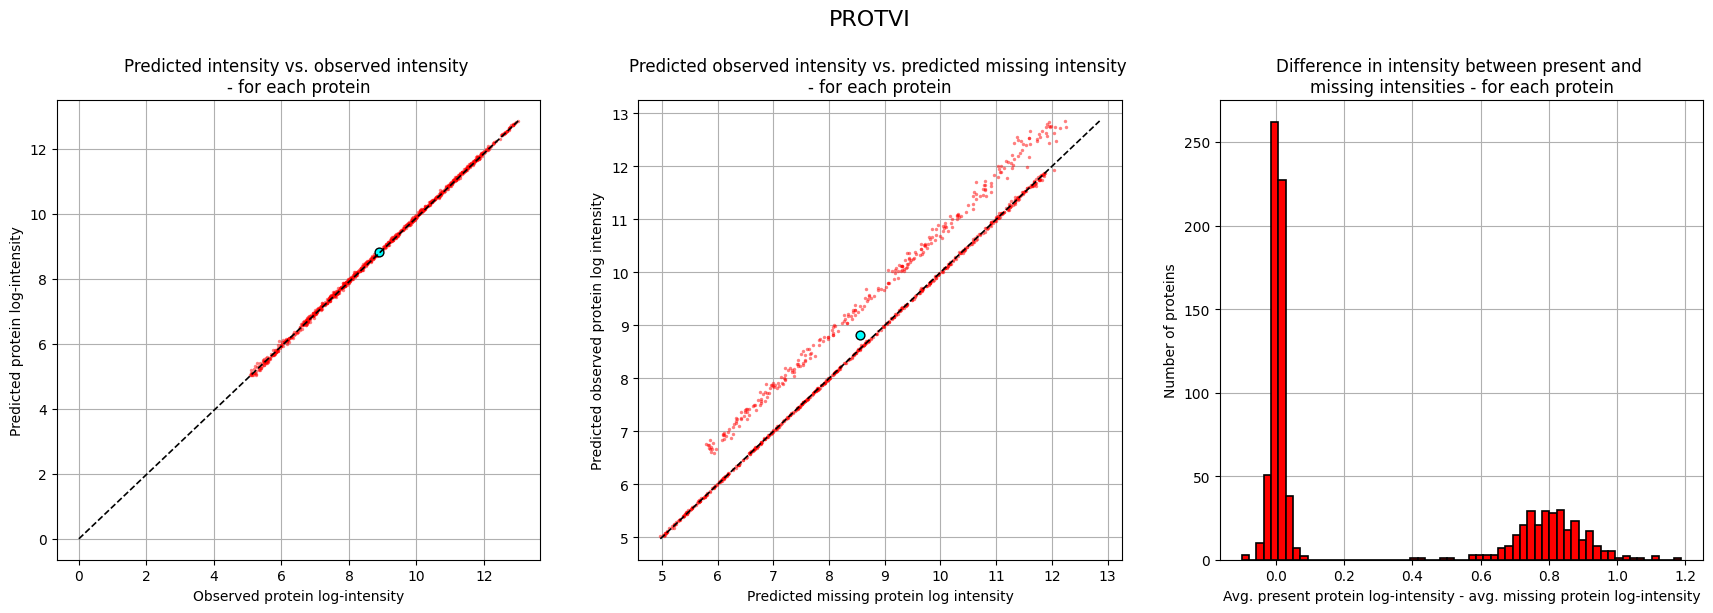

In [13]:
pl.plot_protein_intensity_panel(x_data, x_est, title="PROTVI")

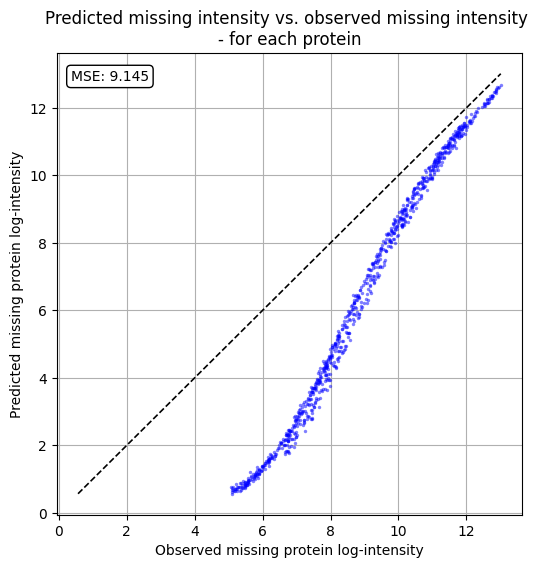

In [18]:
mask = adata.layers["detected"]

x_est_protein = np.nanmean(x_est * mask, axis=0)
x_protein = np.nanmean(x_data * mask, axis=0)

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(x_protein, x_est_protein, color="blue", edgecolor="black", linewidth=0, s=6, alpha=0.5)
v_min = min(x_protein.min(), x_est_protein.min())
v_max = max(x_protein.max(), x_est_protein.max())
ax.plot([v_min, v_max], [v_min, v_max], color="black", linewidth=1.2, linestyle="--")

mse = np.mean((x_protein - x_est_protein) ** 2)
ax.text(0.03, 0.94, f"MSE: {mse:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)

ax.set_xlabel("Observed missing protein log-intensity")
ax.set_ylabel("Predicted missing protein log-intensity")
ax.set_title("Predicted missing intensity vs. observed missing intensity \n- for each protein")
ax.grid(True)
ax.set_axisbelow(True)

### protDP

In [14]:
# @TODO

### Other impuation methods

In [15]:
# @TODO